In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv,DataFrame,concat

from sklearn.preprocessing import LabelEncoder,MinMaxScaler

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM

import os
path='E:\【ML_DL】\【服装项目】\dataset\shopN\data\shop_'

Using TensorFlow backend.


销售数据取自data_full.7z中的'sale_XXX.csv'系列csv文件，将所有sale数据进行合并。一共有638家店铺，其中取出：拥有数据数目大于100条可以用于lstm时序预测、以及日期可以满足预测条件的店铺，用shop_newest_len100表示       

In [2]:
shop_newest_len100 = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 54, 56, 57, 58, 59, 61, 62, 63, 64, 65, 69, 70, 72, 75, 76, 77, 78, 81, 83, 85, 86, 88, 89, 90, 91, 93, 94, 95, 100, 101, 105, 106, 107, 110, 111, 114, 115, 121, 122, 125, 127, 128, 132, 133, 134, 135, 146, 147, 151, 156, 157, 158, 159, 160, 162, 163, 164, 167, 169, 170, 172, 178, 179, 183, 185, 186, 189, 196, 199, 200, 201, 205, 206, 209, 218, 221, 223, 225, 233, 234, 237, 239, 246, 250, 260, 272, 299, 308, 311, 321, 451, 481]

保存每个店铺的数据长度

In [3]:
shop_length = []# 保存每个店铺的数据长度
for id in shop_newest_len100:
    df = pd.read_csv(path+str(id)+'.csv',low_memory=False)
    shop_length.append(len(df))

In [4]:
shop_length[:10]

[225, 558, 558, 446, 366, 331, 513, 177, 362, 497]

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 定义相对误差的计算
def mean_squared_error01(a,b):
    e=[]
    for i in range(len(a)):
        dif = a[i]-b[i]
        e1 = abs(dif / b[i])
        e.append(e1)
    return e

这里随机选取第3个店铺进行展示

In [3]:
id = 3# 这里随机选取第7个店铺进行展示
df = pd.read_csv(path+str(id)+'.csv',low_memory=False)
# df=df.drop(['sale_date'],axis=1)
len(df)

558

数据清洗

In [4]:
df=df.dropna()
df=df[df['sale_price']!=0]
len(df)

550

查看修改前，以【周】销售单位的数据

In [5]:
df[:5]

,sale_date,sale_price,Quantity
0,2008-02-25,11498.0,32.0
1,2008-03-03,39564.0,112.0
2,2008-03-10,35512.0,93.0
3,2008-03-17,54505.0,166.0
4,2008-03-24,29449.0,120.0


In [6]:
df['sale_date']=pd.to_datetime(df['sale_date'], format="%Y/%m/%d")
df.set_index('sale_date', inplace=True)

In [7]:
df = df.resample('Q').sum()

In [8]:
len(df)

44

查看修改后，以【季度】为销售单位的数据

In [9]:
df=df[df['sale_price']!=0]
len(df)

44

In [16]:
df[:5]

,sale_price,Quantity
sale_date,,
2008-03-31,216877.0,682.0
2008-06-30,326247.0,1371.0
2008-09-30,595867.5,2521.0
2008-12-31,759451.5,2234.0
2009-03-31,692872.5,2247.0


In [10]:
# 区间缩放
values = df.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

valuess = reframed.values

# 2018年所有数据是倒数44条的数据
num_2018 = 4

train = valuess[:(len(valuess)-num_2018), :]#513-45=468
test = valuess[(len(valuess)-num_2018):, :]

train_X, train_y = train[:, :-2], train[:, -2]
test_X, test_y = test[:, :-2], test[:, -2]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

测试集         
[销售额, 销售数量]

In [10]:
# values[469:469+5]

In [11]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=100, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 39 samples, validate on 4 samples
Epoch 1/100
 - 5s - loss: 0.4533 - val_loss: 0.3860
Epoch 2/100
 - 0s - loss: 0.4267 - val_loss: 0.3573
Epoch 3/100
 - 0s - loss: 0.3985 - val_loss: 0.3277
Epoch 4/100
 - 0s - loss: 0.3696 - val_loss: 0.2973
Epoch 5/100
 - 0s - loss: 0.3398 - val_loss: 0.2801
Epoch 6/100
 - 0s - loss: 0.3122 - val_loss: 0.2631
Epoch 7/100
 - 0s - loss: 0.2853 - val_loss: 0.2456
Epoch 8/100
 - 0s - loss: 0.2582 - val_loss: 0.2276
Epoch 9/100
 - 0s - loss: 0.2338 - val_loss: 0.2094
Epoch 10/100
 - 0s - loss: 0.2109 - val_loss: 0.1912
Epoch 11/100
 - 0s - loss: 0.1916 - val_loss: 0.1742
Epoch 12/100
 - 0s - loss: 0.1769 - val_loss: 0.1581
Epoch 13/100
 - 0s - loss: 0.1670 - val_loss: 0.1435
Epoch 14/100
 - 0s - loss: 0.1615 - val_loss: 0.1348
Epoch 15/100
 - 0s - loss: 0.1581 - val_loss: 0.1337
Epoch 16/100
 - 0s - loss: 0.1568 - val_loss: 0.1326
Epoch 17/100
 - 0s - loss: 0.1564 - val_loss: 0.1316
Epoch 18/100
 - 0s - loss: 0.1560 - val_loss: 0.1307
Epoch 19/100

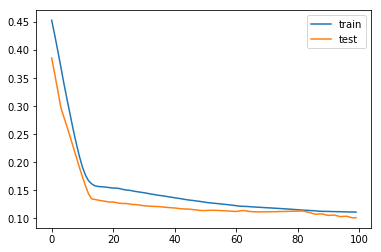

In [12]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
yhat = model.predict(test_X)

yhat.reshape((len(yhat), ))

rmse = mean_squared_error01(test_y,yhat)
print('rmse[:]:\n',rmse[:])# 2018年最后一个时间单位（季度）的销售数据不完整，需要剔除
error = sum(rmse[:])/(len(test_y))

print('error:\n',error)

rmse[:]:
 [array([0.06598418], dtype=float32), array([0.10177848], dtype=float32), array([0.05885361], dtype=float32), array([0.6964121], dtype=float32)]
error:
 [0.23075709]


##### 因为之前做了归一化，现在要将0-1的数据还原到原来的范围

测试集          
[销售额、销售数量]

In [15]:
values[-4:]

array([[1.453428e+06, 1.853000e+03],
       [1.158647e+06, 2.232000e+03],
       [1.027289e+06, 1.961000e+03],
       [4.452900e+05, 6.780000e+02]], dtype=float32)

In [16]:
# invert scaling for forecast
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_yy=test_y.reshape((len(test_y),1 ))

inv_y = concatenate((test_yy, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [17]:
inv_y

array([[1453428.    ,    2023.    ],
       [1158647.1   ,    1853.    ],
       [1027288.94  ,    2232.0002],
       [ 445290.    ,    1961.    ]], dtype=float32)

In [18]:
y1=inv_y

In [19]:
inv_ypred = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_ypred = scaler.inverse_transform(inv_ypred)

In [20]:
inv_ypred

array([[1376885.8   ,    2023.    ],
       [1265360.    ,    1853.    ],
       [1077967.1   ,    2232.0002],
       [ 969255.3   ,    1961.    ]], dtype=float32)

In [21]:
y2=inv_ypred

预测2018年销售额的相对误差

In [22]:
a1=sum(y1)
a1

array([4084654.,    8069.], dtype=float32)

In [23]:
a2=sum(y2)
a2

array([4689468.5,    8069. ], dtype=float32)

In [24]:
abs(a1[0]-a2[0])/a1[0]

0.14806995